# Lab 8 Solution - DKT Model Comparison

In this exercises, you will compare the performance of different knowledge tracing models. We will use the same ASSISTments data set as for lecture 7.

The ASSISTments data sets are often used for benchmarking knowledge tracing models. We will play with a simplified data set that contains the following columns:

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| user_id | The ID of the student who is solving the problem.  | |
| order_id | The temporal ID (timestamp) associated with the student's answer to the problem.  | |
| skill_name | The name of the skill associated with the problem. | |
| correct | The student's performance on the problem: 1 if the problem's answer is correct at the first attempt, 0 otherwise. 

Note that this notebook will need to use the tensorflow kernel. Change the kernel in the upper right corner of Noto. Select `tensorflow`.

We first load the data set.

In [3]:
# Principal package imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, roc_auc_score

# PyBKT package imports
from pyBKT.models import Model
# Import the lmm model class
from pymer4.models import Lmer

# Tensorflow
import tensorflow as tf

DATA_DIR = "./../../data/"

In [4]:
assistments = pd.read_csv(DATA_DIR + 'assistments.csv', low_memory=False).dropna()
assistments.head()

,user_id,order_id,skill_name,correct
0,64525,33022537,Box and Whisker,1
1,64525,33022709,Box and Whisker,1
2,70363,35450204,Box and Whisker,0
3,70363,35450295,Box and Whisker,1
4,70363,35450311,Box and Whisker,0


Next, we print the number of unique students and skills in this data set.

In [5]:
print("Number of unique students in the dataset:", len(set(assistments['user_id'])))
print("Number of unique skills in the dataset:", len(set(assistments['skill_name'])))

Number of unique students in the dataset: 4151
Number of unique skills in the dataset: 110


We also implement a utility function that splits the data in two folds, making sure that all interactions of a student land in the same fold. We will use this function later when comparing predictive performance of the different models.

In [12]:
def create_iterator(data):
    '''
    Create an iterator to split interactions in data into train and test, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''    
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupShuffleSplit(n_splits=1, train_size=.8, test_size=0.2, random_state=0).split(X, groups=groups)

## Additive Factors Model (AFM) and Performance Factors Analysis (PFA)

The AFM and PFA models are both based on logistic regression and item response theory (IRT). Specifically, they compute the probability that a student will solve a task correctly based on the number of previous attempts the student had at the corresponding skill (in case of AFM) and based on the correct and wrong attempts at the corresponding skill (in case of PFA), respectively. We therefore first preprocess the data to compute these variables. For demonstration purposes, we will continue on the small subset of the data set containing six skills.

In [13]:
skills_subset = ['Circle Graph', 'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle']
data = assistments[assistments['skill_name'].isin(skills_subset)]

print("Skill set:", set(data['skill_name']))
print("Number of unique students in the subset:", len(set(data['user_id'])))
print("Number of unique skills in the subset:", len(set(data['skill_name'])))

Skill set: {'Finding Percents', 'Venn Diagram', 'Area Rectangle', 'Mode', 'Circle Graph', 'Division Fractions'}
Number of unique students in the subset: 1527
Number of unique skills in the subset: 6


In [14]:
# Data processing
# Number of attempts before current
def preprocess_data(data):
    data.loc[:, 'aux'] = 1
    data.loc[:, 'prev_attempts'] = data.sort_values('order_id').groupby(['user_id', 'skill_name'])['aux'].cumsum() -1

    # Number of correct and incorrect attempts before current attempt
    data.loc[:, 'correct_aux'] = data.sort_values('order_id').groupby(['user_id', 'skill_name'])['correct'].cumsum()
    data.loc[:, 'before_correct_num'] = data.sort_values('order_id').groupby(['user_id', 'skill_name'])['correct_aux'].shift(periods=1, fill_value=0)
    data.loc[:, 'before_wrong_num'] = data['prev_attempts'] - data['before_correct_num']
    return data

data = preprocess_data(data)
data.head()

/tmp/ipykernel_857/3193894825.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'aux'] = 1
/tmp/ipykernel_857/3193894825.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'prev_attempts'] = data.sort_values('order_id').groupby(['user_id', 'skill_name'])['aux'].cumsum() -1
/tmp/ipykernel_857/3193894825.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

,user_id,order_id,skill_name,correct,aux,prev_attempts,correct_aux,before_correct_num,before_wrong_num
3957,14,21617623,Circle Graph,0,1,0,0,0,0
3958,14,21617632,Circle Graph,1,1,1,1,0,1
3959,14,21617641,Circle Graph,0,1,2,1,1,1
3960,14,21617650,Circle Graph,0,1,3,1,1,2
3961,14,21617659,Circle Graph,0,1,4,1,1,3


Next, we split the data into a training and a test data set.

In [15]:
# Obtain indexes
train_index, test_index = next(create_iterator(data))
# Split the data
X_train, X_test = data.iloc[train_index], data.iloc[test_index]

Next, we fit an AFM model to the training data and predict on the test data. Note that the implementation below only works for a one-to-one correspondance of task and skill, i.e. when a task is associated to exactly one skill. In case of a data set containing tasks with multiple skills, we would need to use the [pyAFM](https://github.com/cmaclell/pyAFM) package. A tutorial on using pyAFM can be found [here](https://github.com/epfl-ml4ed/mlbd-2021/tree/main/Tutorials/Tutorial06/Tutorial06).

In [ ]:
# Initialize and fit the model
model = Lmer("correct ~ (1|user_id) + (1|skill_name) + (0 + prev_attempts|skill_name)", data=X_train, family='binomial')
%time model.fit() 
# Compute predictions
X_test['afm_predictions'] = model.predict(data=X_test, verify_predictions=False)
X_test.head()

Formula: correct~(1|user_id)+(1|skill_name)+(0+prev_attempts|skill_name)

Family: binomial	 Inference: parametric

Number of observations: 40258	 Groups: {'user_id': 1221.0, 'skill_name': 6.0}

Log-likelihood: -16797.782 	 AIC: 33603.565

Random effects:

                       Name     Var     Std
user_id         (Intercept) 2.56000 1.60000
skill_name      (Intercept) 0.68300 0.82700
skill_name.1  prev_attempts 0.00500 0.06900

No random effect correlations specified

Fixed effects:

CPU times: user 24.6 s, sys: 80 ms, total: 24.7 s
Wall time: 24.7 s


/tmp/ipykernel_857/736728277.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['afm_predictions'] = model.predict(data=X_test, verify_predictions=False)


,user_id,order_id,skill_name,correct,aux,prev_attempts,correct_aux,before_correct_num,before_wrong_num,afm_predictions
3969,64525,28186893,Circle Graph,1,1,0,1,0,0,0.48266
3970,64525,28187093,Circle Graph,1,1,1,2,1,0,0.49251
3971,64525,32413158,Circle Graph,1,1,2,3,2,0,0.50236
3972,64525,33022751,Circle Graph,0,1,3,3,3,0,0.51221
3973,64525,33023039,Circle Graph,1,1,4,4,3,1,0.52205


Next, we fit a PFA model to the data. Again, this implementation works for one-to-one correspondance and tasks with multiple skills would require the use of [pyAFM](https://github.com/cmaclell/pyAFM).

In [ ]:
# Initialize and fit the model
model = Lmer("correct ~ (1|user_id) + (1|skill_name) + (0 + before_correct_num|skill_name) + (0 + before_wrong_num|skill_name)", data=X_train, family='binomial')
%time model.fit() 
# Compute predictions
X_test['pfa_predictions'] = model.predict(data=X_test, verify_predictions=False)
X_test.head()

Formula: correct~(1|user_id)+(1|skill_name)+(0+before_correct_num|skill_name)+(0+before_wrong_num|skill_name)

Family: binomial	 Inference: parametric

Number of observations: 40258	 Groups: {'user_id': 1221.0, 'skill_name': 6.0}

Log-likelihood: -16385.969 	 AIC: 32781.939

Random effects:

                            Name     Var     Std
user_id              (Intercept) 1.74800 1.32200
skill_name           (Intercept) 0.69900 0.83600
skill_name.1  before_correct_num 0.02600 0.16200
skill_name.2    before_wrong_num 0.00000 0.01000

No random effect correlations specified

Fixed effects:

CPU times: user 1min 10s, sys: 208 ms, total: 1min 10s
Wall time: 1min 10s


/tmp/ipykernel_857/1100232259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pfa_predictions'] = model.predict(data=X_test, verify_predictions=False)


,user_id,order_id,skill_name,correct,aux,prev_attempts,correct_aux,before_correct_num,before_wrong_num,afm_predictions,pfa_predictions
3969,64525,28186893,Circle Graph,1,1,0,1,0,0,0.48266,0.46224
3970,64525,28187093,Circle Graph,1,1,1,2,1,0,0.49251,0.48999
3971,64525,32413158,Circle Graph,1,1,2,3,2,0,0.50236,0.51780
3972,64525,33022751,Circle Graph,0,1,3,3,3,0,0.51221,0.54551
3973,64525,33023039,Circle Graph,1,1,4,4,3,1,0.52205,0.54598


## Deep Knowledge Tracing (DKT)

Knowledge tracing is one of the key research areas for empowering personalized education. It is a task to model students' mastery level of a skill based on their historical learning trajectories. In recent years, a recurrent neural network model called deep knowledge tracing (DKT) has been proposed to handle the knowledge tracing task and literature has shown that DKT generally outperforms traditional methods.

Next, we will create and evaluate DKT models on top of a TensorFlow framework. For those who are not familiar with this framework, we recommended to follow the [official tutorials](https://www.tensorflow.org/tutorials/quickstart/beginner). 

We continue to work with the small subset (six skills of the data). Furthermore, we will continue to use the same train test split as before.

### Data preparation
A DKT model is characterized by the following main three components:
- **Input**: the one-hot encoded observations at varying time steps. 
- **Network**: a recurrent neural network that processes the one-hot encoded observations in a time-wise manner. 
- **Output**: the probabilities for answering skill (or item) correct at the varying time steps.  

The first step to enable a DKT experimental pipeline requires to prepare the input and output data to be fed into the model during the training and evaluation phases. TensorFlow has an API, called [TF Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), that supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern: (i) create a source dataset from your input data, (ii) apply dataset transformations to preprocess the data, (iii) iterate over the dataset and process the elements. Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

In [ ]:
def prepare_seq(df):
    # Step 1 - Enumerate skill id
    df['skill'], skill_codes = pd.factorize(df['skill_name'], sort=True)

    # Step 2 - Cross skill id with answer to form a synthetic feature
    df['skill_with_answer'] = df['skill'] * 2 + df['correct']

    # Step 3 - Convert to a sequence per user id and shift features 1 timestep
    seq = df.groupby('user_id').apply(lambda r: (r['skill_with_answer'].values[:-1], r['skill'].values[1:], r['correct'].values[1:],))
    
    # Step 4- Get max skill depth and max feature depth
    skill_depth = df['skill'].max() 
    features_depth = df['skill_with_answer'].max() + 1

    return seq, features_depth, skill_depth

In [ ]:
def prepare_data(seq, params, features_depth, skill_depth):
    
    # Step 1 - Get Tensorflow Dataset
    dataset = tf.data.Dataset.from_generator(generator=lambda: seq, output_types=(tf.int32, tf.int32, tf.float32))

    # Step 2 - Encode categorical features and merge skills with labels to compute target loss.
    dataset = dataset.map(
        lambda feat, skill, label: (
            tf.one_hot(feat, depth=features_depth),
            tf.concat(values=[tf.one_hot(skill, depth=skill_depth), tf.expand_dims(label, -1)], axis=-1)
        )
    )

    # Step 3 - Pad sequences per batch
    dataset = dataset.padded_batch(
        batch_size=params['batch_size'],
        padding_values=(params['mask_value'], params['mask_value']),
        padded_shapes=([None, None], [None, None]),
        drop_remainder=True
    )

    return dataset.repeat(), len(seq)

The data needs to be fed into the model in batches. Therefore, we need to specify in advance how many elements per batch our DKT will receive. Furthermore, all sequences should be of the same length in order to be fed into the model. Given that students have different number of opportunities across skills, we need to define a masking value for those entries that are introduced as a padding into the student's sequences.

In [ ]:
params = {}
params['batch_size'] = 32
params['mask_value'] = -1.0

We are now ready to encode the data and split into a training, validation, and test set.

In [ ]:
# Obtain indexes for necessary validation set
train_val_index, val_index = next(create_iterator(X_train))
# Split the training data into training and validation
X_train_val, X_val = X_train.iloc[train_val_index], X_train.iloc[val_index]

seq, features_depth, skill_depth = prepare_seq(data)
seq_train = seq[X_train.user_id.unique()]
seq_val = seq[X_train_val.user_id.unique()]
seq_test = seq[X_test.user_id.unique()]

tf_train, length = prepare_data(seq_train, params, features_depth, skill_depth)
tf_val, val_length  = prepare_data(seq_val, params, features_depth, skill_depth)
tf_test, test_length = prepare_data(seq_test, params, features_depth, skill_depth)

params['train_size'] = int(length // params['batch_size'])
params['val_size'] = int(val_length // params['batch_size'])
params['test_size'] = int(test_length // params['batch_size'])

/tmp/ipykernel_857/2886616435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['skill'], skill_codes = pd.factorize(df['skill_name'], sort=True)
/tmp/ipykernel_857/2886616435.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['skill_with_answer'] = df['skill'] * 2 + df['correct']
2023-04-14 13:32:18.681226: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2

### Model Creation

Next, we create and compile the model. To do so, we first define the necessary parameters.

In [ ]:
params['verbose'] = 1 # Verbose = {0,1,2}
params['best_model_weights'] = 'weights/bestmodel' # File to save the model
params['optimizer'] = 'adam' # Optimizer to use
params['backbone_nn'] = tf.keras.layers.RNN # Backbone neural network
params['recurrent_units'] = 16 # Number of RNN units
params['epochs'] = 10  # Number of epochs to train
params['dropout_rate'] = 0.3 # Dropout rate

Considering that we padded the sequences such that all have the same length, we need to remove predictions on the time step associated with padding. We also need to mach each output with a specific skill.
To this end, we implement a function calle get_target. 

In [ ]:
def get_target(y_true, y_pred, mask_value=params['mask_value']):
    
    # Get skills and labels from y_true
    mask = 1. - tf.cast(tf.equal(y_true, mask_value), y_true.dtype)
    y_true = y_true * mask

    skills, y_true = tf.split(y_true, num_or_size_splits=[-1, 1], axis=-1)

    # Get predictions for each skill
    y_pred = tf.reduce_sum(y_pred * skills, axis=-1, keepdims=True)

    return y_true, y_pred

While training the model, we will monitor the following evaluation metrics.

In [ ]:
class AUC(tf.keras.metrics.AUC):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(AUC, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

class RMSE(tf.keras.metrics.RootMeanSquaredError):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(RMSE, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)
        
def CustomBinaryCrossEntropy(y_true, y_pred):    
    y_true, y_pred = get_target(y_true, y_pred)
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)   

We are now ready to create the model.

In [ ]:
def create_model(nb_features, nb_skills, params):
    
    # Create the model architecture
    inputs = tf.keras.Input(shape=(None, nb_features), name='inputs')
    x = tf.keras.layers.Masking(mask_value=params['mask_value'])(inputs)
    x = tf.keras.layers.LSTM(params['recurrent_units'], return_sequences=True, dropout=params['dropout_rate'])(x)
    dense = tf.keras.layers.Dense(nb_skills, activation='sigmoid')
    outputs = tf.keras.layers.TimeDistributed(dense, name='outputs')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='DKT')

    # Compile the model
    model.compile(loss=CustomBinaryCrossEntropy, 
                  optimizer=params['optimizer'], 
                  metrics=[AUC(), RMSE()])
    
    return model

model = create_model(features_depth, skill_depth, params)

In [ ]:
model.summary()

Model: "DKT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 12)]        0         
                                                                 
 masking (Masking)           (None, None, 12)          0         
                                                                 
 lstm (LSTM)                 (None, None, 16)          1856      
                                                                 
 outputs (TimeDistributed)   (None, None, 5)           85        
                                                                 
Total params: 1,941
Trainable params: 1,941
Non-trainable params: 0
_________________________________________________________________


### Model Fitting and Evaluation

Finally, we fit the model on the training data and evaluate it on the test data.
We are using a callback for the model, i.e. we store the best model (on the validation set) and then use this model for prediction.

In [ ]:
ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights'], save_best_only=True, save_weights_only=True)
history = model.fit(tf_train, epochs=params['epochs'], steps_per_epoch=params['train_size'], 
                    validation_data=tf_val,  validation_steps = params['val_size'], 
                    callbacks=[ckp_callback], verbose=params['verbose'])

Epoch 1/10
38/38 [==============================] - 13s 219ms/step - loss: 0.8645 - auc: 0.5299 - root_mean_squared_error: 0.6772 - val_loss: 0.8615 - val_auc: 0.5734 - val_root_mean_squared_error: 0.6777
Epoch 2/10
38/38 [==============================] - 8s 212ms/step - loss: 0.8592 - auc: 0.5792 - root_mean_squared_error: 0.6667 - val_loss: 0.8556 - val_auc: 0.5861 - val_root_mean_squared_error: 0.6668
Epoch 3/10
38/38 [==============================] - 7s 174ms/step - loss: 0.8537 - auc: 0.5893 - root_mean_squared_error: 0.6551 - val_loss: 0.8489 - val_auc: 0.5883 - val_root_mean_squared_error: 0.6549
Epoch 4/10
38/38 [==============================] - 6s 166ms/step - loss: 0.8473 - auc: 0.5919 - root_mean_squared_error: 0.6434 - val_loss: 0.8426 - val_auc: 0.5862 - val_root_mean_squared_error: 0.6453
Epoch 5/10
38/38 [==============================] - 7s 183ms/step - loss: 0.8432 - auc: 0.5906 - root_mean_squared_error: 0.6345 - val_loss: 0.8379 - val_auc: 0.5863 - val_root_mean_s

We evaluate on the test data set and print the results.

In [ ]:
model.load_weights(params['best_model_weights'])
metrics_dkt_small = model.evaluate(tf_test, verbose=params['verbose'], steps = params['test_size'])

9/9 [==============================] - 1s 46ms/step - loss: 0.6262 - auc: 0.6545 - root_mean_squared_error: 0.5911


In [ ]:
# Binary cross entropy, AUC, RMSE
metrics_dkt_small

[0.6262012124061584, 0.6544973850250244, 0.5910719037055969]

## BKT

We first also fit a BKT model to this data set using the same train/test split as above.

In [ ]:
df_preds = pd.DataFrame()

# Train a BKT model for each skill
for skill in skills_subset:
    print("--{}--".format(skill))
    X_train_skill = X_train[X_train['skill_name'] == skill]
    X_test_skill = X_test[X_test['skill_name'] == skill]
    # Initialize and fit the model
    model = Model(seed=0)
    %time model.fit(data=X_train_skill) 
    preds = model.predict(data=X_test_skill) [['user_id', 'order_id', 'skill_name', 'correct', 'prev_attempts',
       'before_correct_num', 'before_wrong_num', 'afm_predictions', 'pfa_predictions', 'correct_predictions']]
    df_preds = df_preds.append(preds)

X_test = df_preds
X_test.columns = ['user_id', 'order_id', 'skill_name', 'correct', 'prev_attempts',
       'before_correct_num', 'before_wrong_num', 'afm_predictions', 'pfa_predictions', 'bkt_predictions']
X_test.head()

--Circle Graph--
CPU times: user 6.39 s, sys: 0 ns, total: 6.39 s
Wall time: 6.78 s
--Venn Diagram--
CPU times: user 5 s, sys: 0 ns, total: 5 s
Wall time: 5.38 s
--Mode--
CPU times: user 8.29 s, sys: 0 ns, total: 8.29 s
Wall time: 8.69 s
--Division Fractions--
CPU times: user 6.7 s, sys: 0 ns, total: 6.7 s
Wall time: 6.98 s
--Finding Percents--
CPU times: user 7 s, sys: 0 ns, total: 7 s
Wall time: 7.48 s
--Area Rectangle--
CPU times: user 3.68 s, sys: 0 ns, total: 3.68 s
Wall time: 3.88 s


,user_id,order_id,skill_name,correct,prev_attempts,before_correct_num,before_wrong_num,afm_predictions,pfa_predictions,bkt_predictions
3969,64525,28186893,Circle Graph,1,0,0,0,0.48266,0.46224,0.44987
3970,64525,28187093,Circle Graph,1,1,1,0,0.49251,0.48999,0.63161
3971,64525,32413158,Circle Graph,1,2,2,0,0.50236,0.51780,0.68926
3972,64525,33022751,Circle Graph,0,3,3,0,0.51221,0.54551,0.70119
3973,64525,33023039,Circle Graph,1,4,3,1,0.52205,0.54598,0.69646


In [32]:
X_test.to_csv(DATA_DIR + 'x_test_08.csv.gz', compression = 'gzip', index = False)

# Your Turn 1 - Model Comparison on Subset

Up to now, we have compared model performance on a subset of the data. Your task is to compare and discuss performance of the different models:
1. Visualize the overall RMSE and AUC of the four models (AFM, PFA, BKT, DKT) such that the metrics can be easily compared.
2. Interpret your results and discuss your observations.

In [33]:
import requests

exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)

npt_config = {
    'session_name': 'lecture-08',
    'session_owner': 'mlbd',
    'sender_name': input("Your name: "),
}

Your name:  Antoine


In [34]:
# If it is taking too long to run, you may load our X_test to compute the RMSE and AUC
X_test = pd.read_csv(DATA_DIR + 'x_test_08.csv.gz', compression = 'gzip')

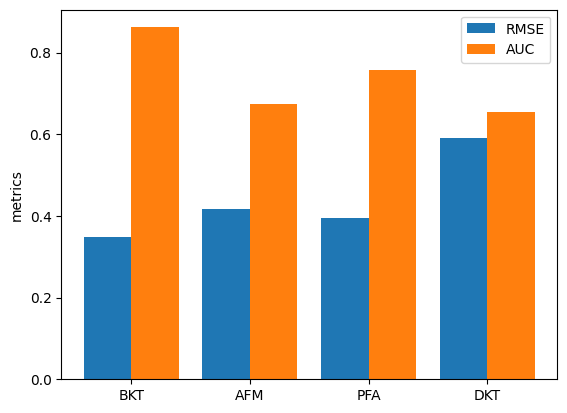

In [44]:
# Visualize plots

rmse_bkt = mean_squared_error(X_test['bkt_predictions'],X_test['correct'], squared = False)
rmse_afm = mean_squared_error(X_test['afm_predictions'],X_test['correct'], squared = False)
rmse_pfa = mean_squared_error(X_test['pfa_predictions'],X_test['correct'], squared = False)
rmse_dkt = metrics_dkt_small[2]

rmse = [rmse_bkt, rmse_afm, rmse_pfa, rmse_dkt]
models = ['BKT', 'AFM', 'PFA', 'DKT']

X_ticks = np.arange(len(models))

plt.bar(X_ticks - 0.2, rmse, 0.4, label='RMSE')

auc_bkt = roc_auc_score(X_test['correct'], X_test['bkt_predictions'])
auc_afm = roc_auc_score(X_test['correct'], X_test['afm_predictions'])
auc_pfa = roc_auc_score(X_test['correct'], X_test['pfa_predictions'])
auc_dkt = metrics_dkt_small[1]

auc = [auc_bkt, auc_afm, auc_pfa, auc_dkt]

plt.bar(X_ticks + 0.2, auc, 0.4, label='AUC')
plt.xticks(X_ticks, models)
plt.ylabel('metrics')
plt.legend()

We observe that BKT outperforms AFM and PFA in terms of RMSE and AUC. Not unexpectedly, PFA is performing better than AFM. Interestingly, DKT performs much worse than the other models in terms of RMSE and is about on par with AFM regarding the AUC. This is probably due to the fact, that the data set (and the number of epochs) are too small for DKT - the only six skills in the data set do not allow the model to infer relations bewteen the skills.

## Model Comparison on Full Data Set

Finally, we compare predictive performance of the models on the full data set. We only compare BKT (the previously best model) and DKT. We first split the data.

In [45]:
data = assistments.copy()
print("Number of unique students in the data:", len(set(data['user_id']))) 
print("Number of unique skills in the data:", len(set(data['skill_name'])))

# Split into train and test
train_index, test_index = next(create_iterator(data))
X_train, X_test = data.iloc[train_index], data.iloc[test_index]
print("Number of unique students in the training data:", len(set(X_train['user_id']))) 
print("Number of unique skills in the training data:", len(set(X_train['skill_name']))) 
print("Number of unique students in the test data:", len(set(X_test['user_id'])))
print("Number of unique skills in the test data:", len(set(X_test['skill_name']))) 

# Then, obtain validation set
train_val_index, val_index = next(create_iterator(X_train))
X_train_val, X_val = X_train.iloc[train_val_index], X_train.iloc[val_index]

Number of unique students in the data: 4151
Number of unique skills in the data: 110
Number of unique students in the training data: 3320
Number of unique skills in the training data: 110
Number of unique students in the test data: 831
Number of unique skills in the test data: 105


### DKT

We again first prepare the data for the DKT model.

In [ ]:
params = {}
params['batch_size'] = 32
params['mask_value'] = -1.0

seq, features_depth, skill_depth = prepare_seq(data)
seq_train = seq[X_train.user_id.unique()]
seq_val = seq[X_train_val.user_id.unique()]
seq_test = seq[X_test.user_id.unique()]

tf_train, length = prepare_data(seq_train, params, features_depth, skill_depth)
tf_val, val_length  = prepare_data(seq_val, params, features_depth, skill_depth)
tf_test, test_length = prepare_data(seq_test, params, features_depth, skill_depth)

params['train_size'] = int(length // params['batch_size'])
params['val_size'] = int(val_length // params['batch_size'])
params['test_size'] = int(test_length // params['batch_size'])

We then again specify the parameters and create the model. Since we have more skills and students, we use a larger model.

In [ ]:
params['verbose'] = 1 # Verbose = {0,1,2}
params['best_model_weights'] = 'weights/bestmodel' # File to save the model
params['optimizer'] = 'adam' # Optimizer to use
params['backbone_nn'] = tf.keras.layers.RNN # Backbone neural network
params['recurrent_units'] = 64 # Number of RNN units
params['epochs'] = 30  # Number of epochs to train
params['dropout_rate'] = 0.3 # Dropout rate

model = create_model(features_depth, skill_depth, params)
model.summary()

Model: "DKT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 220)]       0         
                                                                 
 masking_1 (Masking)         (None, None, 220)         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 64)          18240     
                                                                 
 outputs (TimeDistributed)   (None, None, 109)         7085      
                                                                 
Total params: 25,325
Trainable params: 25,325
Non-trainable params: 0
_________________________________________________________________


We first fit the model on the train data and then evaluate on the test data.

In [ ]:
params['best_model_weights_complete'] = 'weights/bestmodelcomplete'
ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights_complete'], save_best_only=True, save_weights_only=True)
history = model.fit(tf_train, epochs=params['epochs'], steps_per_epoch=params['train_size'], 
                    validation_data=tf_val,  validation_steps = params['val_size'], 
                    callbacks=[ckp_callback], verbose=params['verbose'])

Epoch 1/30
103/103 [==============================] - 439s 4s/step - loss: 0.1946 - auc_1: 0.5749 - root_mean_squared_error: 0.4854 - val_loss: 0.1751 - val_auc_1: 0.6714 - val_root_mean_squared_error: 0.4551
Epoch 2/30
103/103 [==============================] - 364s 4s/step - loss: 0.1820 - auc_1: 0.7206 - root_mean_squared_error: 0.4444 - val_loss: 0.1650 - val_auc_1: 0.7831 - val_root_mean_squared_error: 0.4235
Epoch 3/30
103/103 [==============================] - 601s 6s/step - loss: 0.1766 - auc_1: 0.7531 - root_mean_squared_error: 0.4296 - val_loss: 0.1599 - val_auc_1: 0.8032 - val_root_mean_squared_error: 0.4067
Epoch 4/30
103/103 [==============================] - 337s 3s/step - loss: 0.1707 - auc_1: 0.7898 - root_mean_squared_error: 0.4081 - val_loss: 0.1562 - val_auc_1: 0.8199 - val_root_mean_squared_error: 0.3964
Epoch 5/30
103/103 [==============================] - 316s 3s/step - loss: 0.1678 - auc_1: 0.8019 - root_mean_squared_error: 0.4013 - val_loss: 0.1546 - val_auc_1: 

In [ ]:
model.load_weights(params['best_model_weights_complete'])

In [ ]:
metrics_dkt_full = model.evaluate(tf_test, verbose=params['verbose'], steps = params['test_size'])

25/25 [==============================] - 21s 717ms/step - loss: 0.1288 - auc_1: 0.8575 - root_mean_squared_error: 0.3621


In [ ]:
metrics_dkt_full

### BKT

We then again fit the BKT model.

In [ ]:
df_preds = pd.DataFrame()
# Train a BKT model for each skill
for skill in data['skill_name'].unique():
    print("--{}--".format(skill))
    try:
        X_train_skill = X_train[X_train['skill_name'] == skill]
        X_test_skill = X_test[X_test['skill_name'] == skill]
        model = Model(seed=0)
        %time model.fit(data=X_train_skill) 
        preds = model.predict(data=X_test_skill)[['user_id', 'order_id', 'skill_name', 'correct', 'correct_predictions']]
        df_preds = df_preds.append(preds)
    except:
        print('Skill {} not found in test set'.format(skill))

X_test = df_preds
X_test.columns = ['user_id', 'order_id', 'skill_name', 'correct', 'bkt_predictions']
X_test.head()

--Box and Whisker--
CPU times: user 2.76 s, sys: 0 ns, total: 2.76 s
Wall time: 7.52 s
--Circle Graph--
CPU times: user 2.06 s, sys: 0 ns, total: 2.06 s
Wall time: 2.33 s
--Histogram as Table or Graph--
CPU times: user 853 ms, sys: 0 ns, total: 853 ms
Wall time: 792 ms
--Number Line--
CPU times: user 392 ms, sys: 0 ns, total: 392 ms
Wall time: 355 ms
--Scatter Plot--
CPU times: user 704 ms, sys: 0 ns, total: 704 ms
Wall time: 663 ms
--Stem and Leaf Plot--
CPU times: user 1.75 s, sys: 0 ns, total: 1.75 s
Wall time: 1.76 s
--Table--
CPU times: user 1.83 s, sys: 0 ns, total: 1.83 s
Wall time: 1.74 s
--Venn Diagram--
CPU times: user 3.77 s, sys: 0 ns, total: 3.77 s
Wall time: 3.79 s
--Mean--
CPU times: user 3.18 s, sys: 0 ns, total: 3.18 s
Wall time: 3.14 s
--Median--
CPU times: user 1.73 s, sys: 0 ns, total: 1.73 s
Wall time: 1.7 s
--Mode--
CPU times: user 2.21 s, sys: 0 ns, total: 2.21 s
Wall time: 2.19 s
--Range--
CPU times: user 1.43 s, sys: 0 ns, total: 1.43 s
Wall time: 1.38 s
--Coun

,user_id,order_id,skill_name,correct,bkt_predictions
2,70363,35450204,Box and Whisker,0,0.71789
3,70363,35450295,Box and Whisker,1,0.60606
4,70363,35450311,Box and Whisker,0,0.72707
5,70363,35450555,Box and Whisker,1,0.61645
6,70363,35450573,Box and Whisker,1,0.73387


### Comparison across models

Finally, we again plot the RMSE and AUC for BKT and DKT.

Text(0, 0.5, 'RMSE')

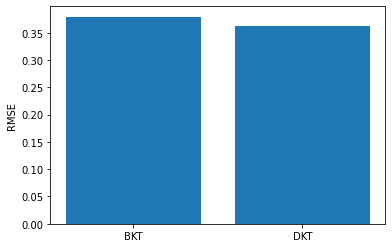

In [ ]:
rmse_bkt = mean_squared_error(X_test['bkt_predictions'],X_test['correct'], squared = False)
rmse_dkt = metrics_dkt_full[2]

rmse = [rmse_bkt, rmse_dkt]
models = ['BKT', 'DKT']

plt.bar(models, rmse)
plt.ylabel('RMSE')

Text(0, 0.5, 'AUC')

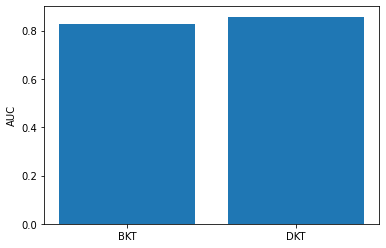

In [ ]:
auc_bkt = roc_auc_score(X_test['correct'], X_test['bkt_predictions'])
auc_dkt = metrics_dkt_full[1]

auc = [auc_bkt, auc_dkt]
models = ['BKT', 'DKT']

plt.bar(models, auc)
plt.ylabel('AUC')

In [ ]:
rmse

[0.37921100290974447, 0.36206743121147156]

In [ ]:
auc

[0.8253168302396643, 0.8575211763381958]

**Which model is doing a better? Discuss your observations.**
- We can see that both BKT and DKT models are very close to each other (have comparable performance) in both AUC and RMSE metrics. However we note that the DKT model performs slightly better across both metrics.

**Are the results different from the results on the subset of the data? If yes, why?**
- Concerning the BKT model, we do not see much difference compared to results on the subset data.
- However, we clearly have different results for the DKT model. In our experiments with more data, we see a big improvement in terms of both AUC and RMSE metrics. As per our knowledge of deep learning techniques, we often observe a large performance increase with a larger amount of data, allowing us to infer that DKT leverages a larger dataset to create an improved model better than BKT does.